(chapter:tensors/mlp)=
# Building a vectorized neural network with tensors

To demonstrate the power of `Tensor`, we'll need a dataset to test out our neural network. We'll use our good old friend, the spiral dataset.

In [1]:
import numpy as np
from mlfz.nn import Tensor


def generate_spiral_dataset(n_points, noise=0.5, twist=380):
    random_points = np.sqrt(np.random.rand(n_points)) * twist * 2 * np.pi / 360

    class_1 = np.column_stack((-np.cos(random_points) * random_points + np.random.rand(n_points) * noise,
                               np.sin(random_points) * random_points + np.random.rand(n_points) * noise))
    class_2 = np.column_stack((np.cos(random_points) * random_points + np.random.rand(n_points) * noise,
                               -np.sin(random_points) * random_points + np.random.rand(n_points) * noise))

    xs = np.vstack((class_1, class_2))
    ys = np.hstack((np.zeros(n_points), np.ones(n_points))).reshape(-1, 1)
    
    return Tensor(xs), Tensor(ys)

In [2]:
xs, ys = generate_spiral_dataset(200, noise=2)

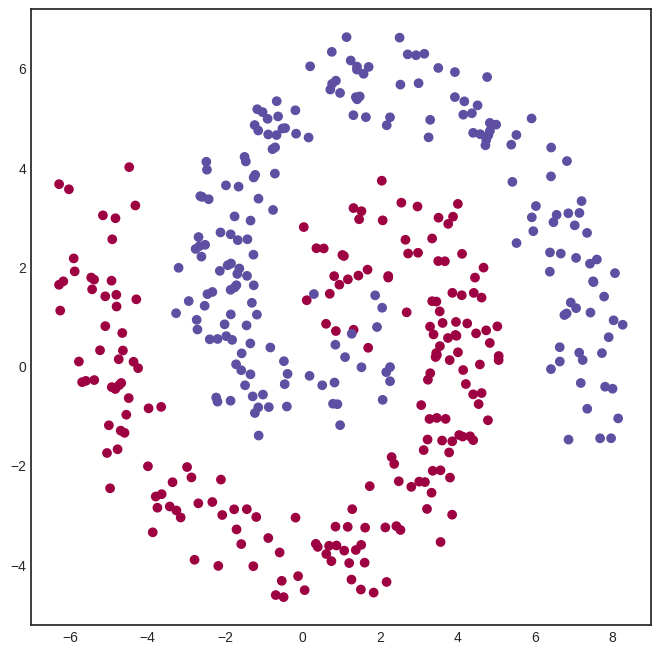

In [3]:
import matplotlib.pyplot as plt


with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral)
    plt.show()

To define a network, we'll once again use the `Model` class from `mlfz.nn`.

In [4]:
from mlfz.nn import Model
from mlfz.nn.tensor.functional import tanh, sigmoid


class TwoLayerNetwork(Model):
    def __init__(self):
        self.A = Tensor.from_random(2, 8)
        self.B = Tensor.from_random(8, 8)
        self.C = Tensor.from_random(8, 1)

    def forward(self, x):
        return sigmoid(tanh(tanh(x @ self.A) @ self.B) @ self.C)
    
    def parameters(self):
        return {"A": self.A, "B": self.B, "C": self.C}

Look at how simple this implementation is, compared to {ref}`the scalar version <computational-graphs:mlp:a-multi-layer-network>`. Writing expressions like `tanh(x @ A)` makes all the difference.

Training tensor networks is also much faster, as we shall see soon. Let's initialize one and see how it looks.

In [5]:
model = TwoLayerNetwork()

/tmp/ipykernel_27708/4170422174.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[i, j] = model.forward(Tensor([xx[i, j], yy[i, j]])).value


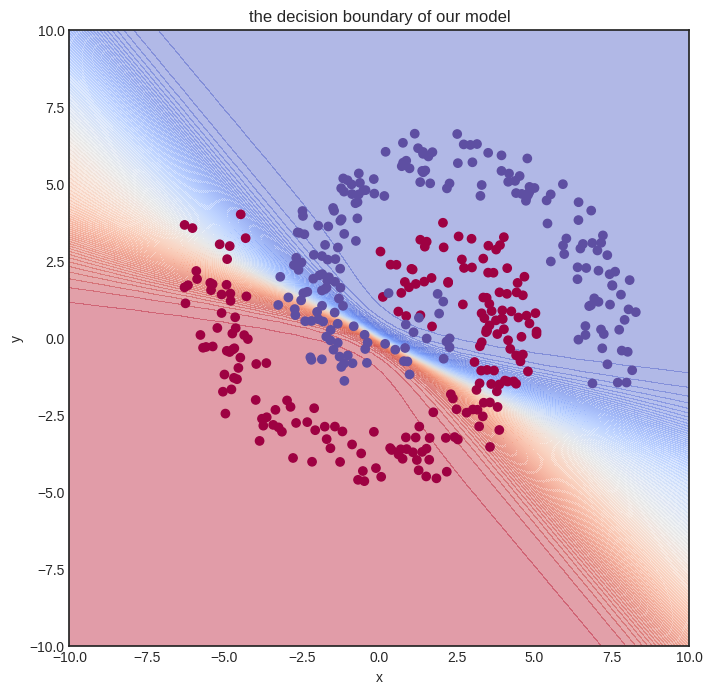

In [6]:
from itertools import product


def visualize_model(model, xs, ys, res=100, xrange=(-10, 10), yrange=(-10, 10)):
    with plt.style.context("seaborn-v0_8-white"):
        plt.figure(figsize=(8, 8))
        
        res = 100
        x = np.linspace(xrange[0], xrange[1], res)
        y = np.linspace(yrange[0], yrange[1], res)
        xx, yy = np.meshgrid(x, y)
        zz = np.zeros_like(xx)
        
        for i, j in product(range(res), range(res)):
            zz[i, j] = model.forward(Tensor([xx[i, j], yy[i, j]])).value


        # plot the decision boundary
        plt.contourf(xx, yy, zz, levels=100, cmap='coolwarm_r', alpha=0.4)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('the decision boundary of our model')
        
        # plot the data
        plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral, zorder=10)
        plt.show()

visualize_model(model, xs, ys)

Here goes the training. We'll let it rip and crunch out a whooping 10000 iterations. For comparison, we merely did 1000 steps for the `Scalar` version, and even that almost made my notebook explode.

In [7]:
from mlfz.nn.tensor.loss import binary_cross_entropy


n_steps = 10000
lr = 0.1

for i in range(1, n_steps + 1):
    preds = model(xs)
    l = binary_cross_entropy(preds, ys)
    l.backward()
    model.gradient_update(lr)

    if i == 1 or i % 1000 == 0:
        print(f"step no. {i}, loss = {l.value}")

step no. 1, loss = 1.1248395260277284
step no. 1000, loss = 0.39341628854334026
step no. 2000, loss = 0.38425249648585286
step no. 3000, loss = 0.3707705432312372
step no. 4000, loss = 0.36157183295898604
step no. 5000, loss = 0.3541537940549706
step no. 6000, loss = 0.3447254945882402
step no. 7000, loss = 0.3385088777367751
step no. 8000, loss = 0.3324970717688863
step no. 9000, loss = 0.3271809804106228
step no. 10000, loss = 0.32290722240051084


In other words, despite having a more complex model and performing way more gradient descent steps, we are still much faster. Let's time it to confirm. We'll only measure a thousand training loops.

In [8]:
def train_model():
    model = TwoLayerNetwork()
    n_steps = 1000
    lr = 0.1

    for i in range(1, n_steps + 1):
        preds = model(xs)
        l = binary_cross_entropy(preds, ys)
        l.backward()
        model.gradient_update(lr)


%timeit -r 1 -n 1 train_model()

1.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


And this is the final result.

/tmp/ipykernel_27708/4170422174.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[i, j] = model.forward(Tensor([xx[i, j], yy[i, j]])).value


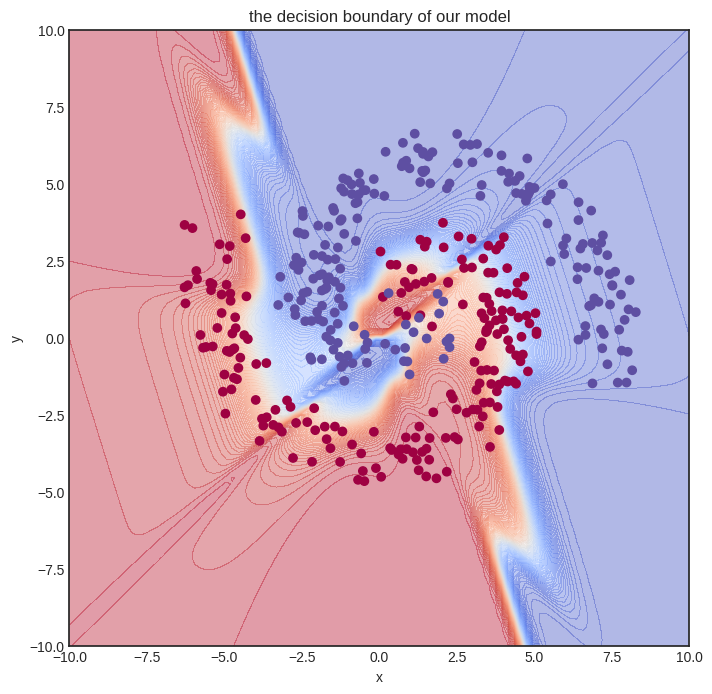

In [9]:
visualize_model(model, xs, ys)

## `Tensor` vs `Scalar` performance comparison

Before moving on to the implementation details, let's quickly compare the performance of `Scalar` vs. `Tensor`. To do that, we'll use a simple one-layer neural network with thirty-two hidden neurons.

We'll store the number of hidden neurons inside a variable so you can play around with it if you execute this notebook locally. 

In [10]:
n_hidden_neurons = 32

First, here's the data. Feel free to skip the code, it's nothing we haven't seen before.

In [11]:
import numpy as np
from mlfz.nn.scalar import Scalar
from mlfz.nn.tensor import Tensor

n_samples = 1000

xs_scalar = [[Scalar.from_random(), Scalar.from_random()] for _ in range(n_samples)]
ys_scalar = [Scalar.from_random() for _ in range(n_samples)]

xs_tensor = Tensor(np.array([[x1.value, x2.value] for x1, x2 in xs_scalar]))
ys_tensor = Tensor(np.array([y.value for y in ys_scalar]).reshape(-1, 1))

Our `Scalar` network takes quite a while to set up. Here we go:

In [12]:
from mlfz import Model
from mlfz.nn.scalar import functional as f_scalar
from itertools import product


class ScalarNetwork(Model):
    def __init__(self):
        self.A = [[Scalar.from_random() for j in range(n_hidden_neurons)]
                  for i in range (2)]
        self.B = [Scalar.from_random() for i in range(n_hidden_neurons)]
    
    def forward(self, x):
        fs = [sum([self.A[i][j] * x[i] for i in range(2)]) for j in range(n_hidden_neurons)]
        fs_relu = [f_scalar.tanh(f) for f in fs]
        gs = sum([self.B[i] * fs_relu[i] for i in range(n_hidden_neurons)])
        return f_scalar.sigmoid(gs)

    def parameters(self):
        A_dict = {f"a{i}{j}": self.A[i][j] for i, j in product(range(2), range(n_hidden_neurons))}
        B_dict = {f"b{i}": self.B[i] for i in range(n_hidden_neurons)}
        return {**A_dict, **B_dict}

To accurately measure the time of a single gradient step, we encapsulate all the logic into a single function called `scalar_network_step`. 

In [13]:
from mlfz.nn.scalar.loss import binary_cross_entropy as bce_scalar


scalar_net = ScalarNetwork()


def scalar_network_step():
    preds = [scalar_net(x) for x in xs_scalar]
    l = bce_scalar(preds, ys_scalar)
    l.backward()
    scalar_net.gradient_update(0.01)
    

Let's go and %timeit!

In [14]:
%timeit scalar_network_step()

293 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now, about the `Tensor` network.

In [15]:
from mlfz.nn.tensor import functional as f_tensor


class TensorNetwork(Model):
    def __init__(self):
        self.A = Tensor.from_random(2, n_hidden_neurons)
        self.B = Tensor.from_random(n_hidden_neurons, 1)

    def forward(self, x):
        return f_tensor.sigmoid(f_tensor.tanh(x @ self.A) @ self.B)
    
    def parameters(self):
        return {"A": self.A, "B": self.B}

Look at that simplicity! Vectorization is worth it for that alone, but wait until we see how fast it is.

In [16]:
from mlfz.nn.tensor.loss import binary_cross_entropy as bce_tensor


tensor_net = TensorNetwork()


def tensor_network_step():
    preds = tensor_net(xs_tensor)
    l = bce_tensor(preds, ys_tensor)
    l.backward()
    tensor_net.gradient_update(0.01)

In [17]:
%timeit tensor_network_step()

3.52 ms ± 124 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The actual performance depends on the server this notebook is built on, but you should see a roughly 100x speedup, given by the magic of vectorization. If you are running this notebook locally, try changing the `n_hidden_neurons` variable in the first executable cell in this notebook. You'll be surprised: the execution time of the `Scalar` version will rapidly increase, but the `Tensor` version will roughly stay the same!

That's because the graph structure adds a heavy overhead to our computations. We'll profile the code in a later version of the notebook, but this is because the actual computations like addition, multiplication, etc, are only a small portion of the training!